<a href="https://colab.research.google.com/github/maxant38/TP-R-seau-de-Neurone/blob/main/TP_R%C3%A9seau_de_Neurones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Indications générales :
1. Le TP se fait impérativement en groupe de 2 ou 3 personnes.
2. Le travail doit être démarré durant la séance de TP, à terminer chez soi
pour être remis sur eCampus avant le 25/11/2022 à 23h55.
3. Un compte rendu obligatoire en format PDF doit être soumis par chaque
groupe avant le 25/11/2022 à 23h55.
4. Dans le compte rendu vous présentez le code utilisé pour résoudre chaque
partie (dans le cas où le code n’est pas donné) ainsi que les résultats
obtenus et l’interprétation détaillée des résultats le cas échéant.
5. L’évaluation est principalement sur votre capacité d’analyser, de critiquer
et d’interpréter les résultats. Ainsi, il est essentiel d’expliquer clairement
vos conclusions.
6. Les codes sont donnés en Python et/ou R-Studio. Mais si vous êtes plus
à l’aise avec un autre langage, n’hésitez pas à l’utiliser.


#**Problème III : Classification**


On suppose que R-Studion et/ou Python sont installés. Nous commençons
par importer les librairies utiles.

Dans cet exercice, il s’agit d’implémenter un réseau de neurones de haute performance pour classifier des personnes, selon plusieurs caractéristiques, en risque élevé (« 1 ») ou risque faible (« 0 ») d’avoir une cardiopathie. Ainsi, à partir du répertoire en ligne "Échantillons de données" de l’ENT, considérez l’échantillon de données intitulé « HD_Complete_Data ». Respecter les consignes suivantes :
1. Diviser votre base de données en 80% pour l’apprentissage et 20% pour le
test.
2. Expliquer comment vous avez réglé le problème des données catégorielles.
3. Vous êtes libre de choisir les paramètres de votre modèle afin d’optimiser la
performance (Vous serez évalué sur les résultats de votre modèle appliqué
aux données test).
4. Expliquer comment vous avez fait pour réduire le surapprentissage 

## **Import des librairies et des données**

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn import preprocessing
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
seed = 123

In [29]:
try:
  req = requests.get('https://raw.githubusercontent.com/maxant38/TP-R-seau-de-Neurone/main/HD_Complete_Data.csv')
except requests.exceptions.RequestException as e:
  print(e)

url_content = req.content
csv_file = open('HD_Complete_Data.csv', 'wb')
csv_file.write(url_content)
csv_file.close()
data =  pd.read_csv('HD_Complete_Data.csv', sep=";")

## **Brève analyse des données**

In [3]:
data.head()

,Age,Sexe,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
data.shape

(918, 12)

In [5]:
data.duplicated().value_counts()

False    918
dtype: int64

Aucune valeur en doublon.


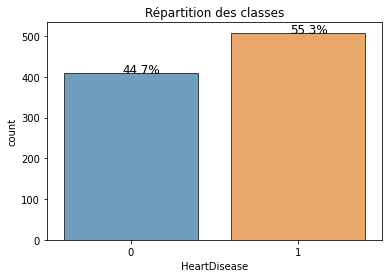

In [29]:
total = float(len(data))

ax = sns.countplot(x="HeartDisease", data=data,edgecolor="black",
              alpha=0.7)

plt.title(f"Répartition des classes")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)
plt.show()

Nous avons la classe 1 qui prédomine un peu mais cela reste léger nous n'avons donc pas besoin de reéaliser des opérations pour réquilibré notre dataset pour la phase de train de notre modèle.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


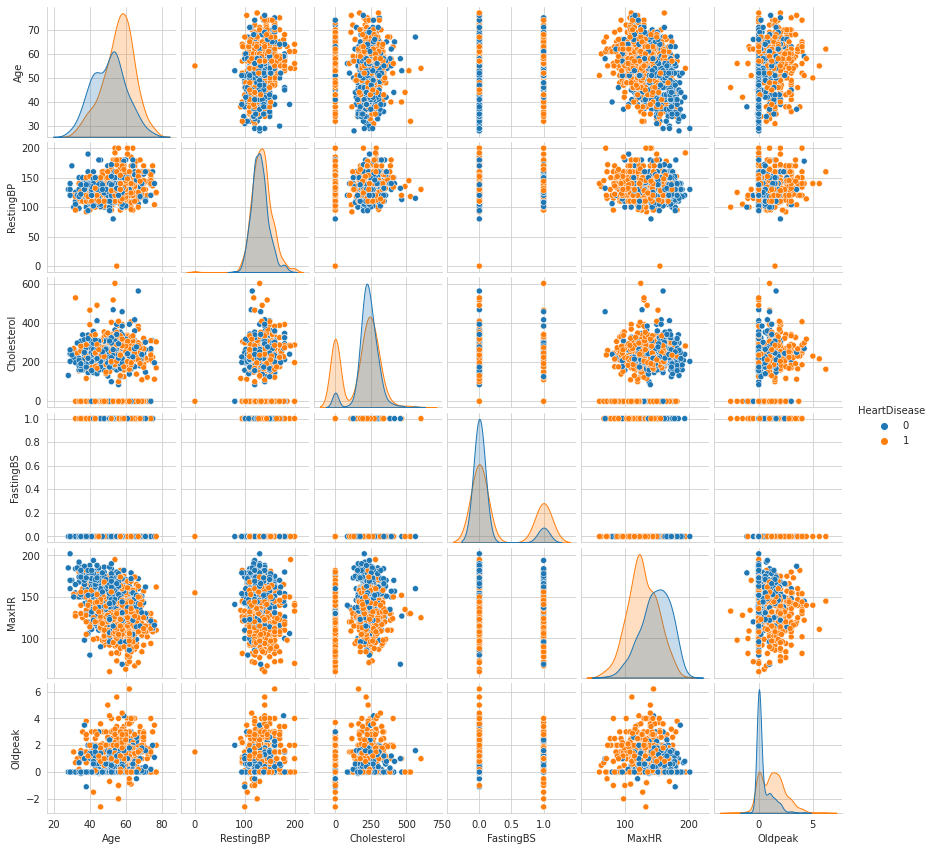

In [31]:
sns.set_style("darkgrid")
sns.pairplot(data,hue="HeartDisease",size=2);
plt.show()


## **Création de nos dataset test & train**`

In [30]:
numCols = data.select_dtypes("number").columns
catCols = data.select_dtypes("object").columns
numCols= list(set(numCols))
catCols= list(set(catCols))
print("variables continues :" + str(numCols)) 
print("varibales catégorielles :" + str(catCols))

variables continues :['Cholesterol', 'Oldpeak', 'FastingBS', 'MaxHR', 'HeartDisease', 'RestingBP', 'Age']
varibales catégorielles :['ChestPainType', 'RestingECG', 'Sexe', 'ST_Slope', 'ExerciseAngina']


In [31]:
# One hot encoding des variables catégorielle
data =pd.get_dummies(data,catCols)


In [32]:
#split en 80-20
x = data.drop(columns="HeartDisease", axis=1)
y = data[['HeartDisease']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

In [33]:
#On normalise nos valeurs

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
# y_train = scaler.fit_transform(y_train)
# y_test = scaler.fit_transform(y_test)

## **Creation de notre modèle**

In [312]:
STEPS_PER_EPOCH= 100000

In [313]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

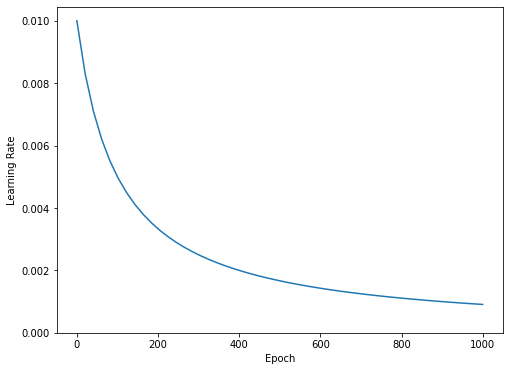

In [314]:
step = np.linspace(0,100000000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [365]:
def compile_and_fit(model, name, optimizer=None, max_epochs=3000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.summary()

  history = model.fit(
    x_train, y_train,
    epochs=max_epochs,
    batch_size=30,
    validation_data=(x_test, y_test),
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                         patience=80,
                         verbose=0),
    verbose=1)
  return history

In [366]:

model_ANN =tf.keras.Sequential([
    layers.Dense(200,input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    layers.Dropout(0.2),
            layers.Dense(100, kernel_regularizer=regularizers.l2(0.001),
                 activation='relu'),
                    layers.Dropout(0.3),
        layers.Dense(68, kernel_regularizer=regularizers.l2(0.001),
                 activation='relu'),
                    layers.Dropout(0.2),
    layers.Dense(40, kernel_regularizer=regularizers.l2(0.001),
                 activation='tanh'),
    layers.Dropout(0.2),
      layers.Dense(20, kernel_regularizer=regularizers.l2(0.001),
                 activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])

In [333]:
size_histories = {}

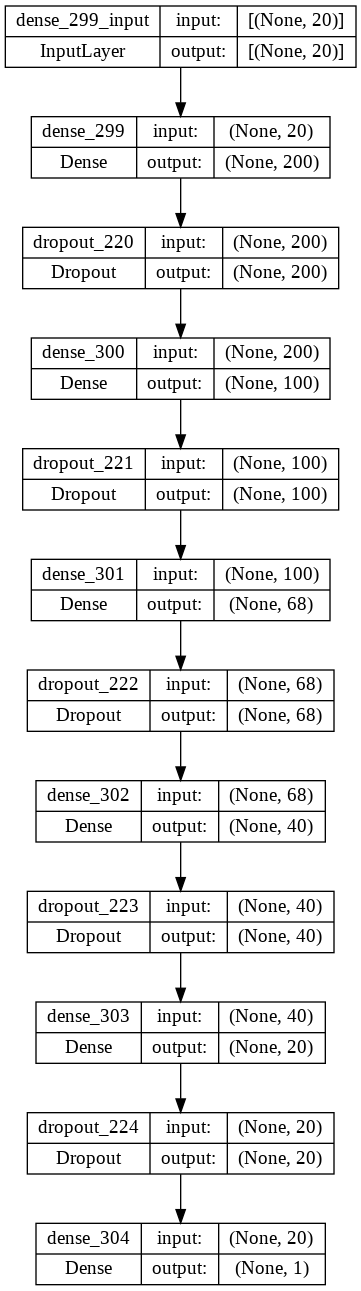

In [350]:
# Or show the model in a plotted graph
keras.utils.plot_model(model_ANN, "Dense Neural Network.png",show_shapes=True)

In [374]:
history = compile_and_fit(model_ANN, 'model')

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_317 (Dense)           (None, 200)               4200      
                                                                 
 dropout_235 (Dropout)       (None, 200)               0         
                                                                 
 dense_318 (Dense)           (None, 100)               20100     
                                                                 
 dropout_236 (Dropout)       (None, 100)               0         
                                                                 
 dense_319 (Dense)           (None, 68)                6868      
                                                                 
 dropout_237 (Dropout)       (None, 68)                0         
                                                                 
 dense_320 (Dense)           (None, 40)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 1s 14ms/step - loss: 0.2909 - accuracy: 0.9292 - val_loss: 0.5093 - val_accuracy: 0.8424
Epoch 2/3000
20/25 [=======================>......] - ETA: 0s - loss: 0.3224 - accuracy: 0.9050

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 0s 5ms/step - loss: 0.3022 - accuracy: 0.9155 - val_loss: 0.4677 - val_accuracy: 0.8424
Epoch 3/3000
25/25 [==============================] - 0s 4ms/step - loss: 0.2538 - accuracy: 0.9401 - val_loss: 0.4930 - val_accuracy: 0.8370
Epoch 4/3000
25/25 [==============================] - 0s 5ms/step - loss: 0.2914 - accuracy: 0.9237 - val_loss: 0.4803 - val_accuracy: 0.8478
Epoch 5/3000
25/25 [==============================] - 0s 4ms/step - loss: 0.2666 - accuracy: 0.9360 - val_loss: 0.5153 - val_accuracy: 0.8587
Epoch 6/3000
25/25 [==============================] - 0s 5ms/step - loss: 0.2652 - accuracy: 0.9305 - val_loss: 0.5683 - val_accuracy: 0.8750
Epoch 7/3000
25/25 [==============================] - 0s 4ms/step - loss: 0.2923 - accuracy: 0.9264 - val_loss: 0.4815 - val_accuracy: 0.8424
Epoch 8/3000
25/25 [==============================] - 0s 4ms/step - loss: 0.2770 - accuracy: 0.9223 - val_loss: 0.4964 - val_accuracy: 0.8478
Epoch 9/3000
25/25 

In [375]:
score = model_ANN.evaluate(x_test, y_test, verbose=0)

print('Test loss     :', score[0])
print('Test accuracy :', score[1])

Test loss     : 0.530188262462616
Test accuracy : 0.85326087474823


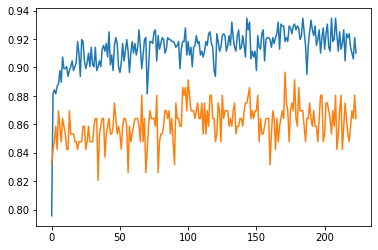

In [355]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

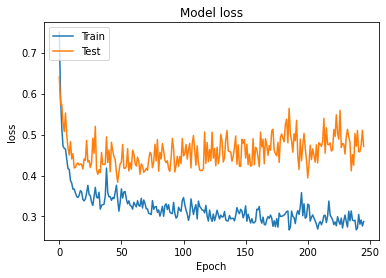

In [369]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

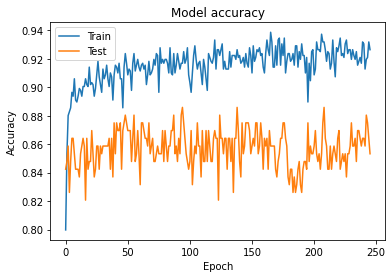

In [370]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

6/6 [==============================] - 0s 3ms/step


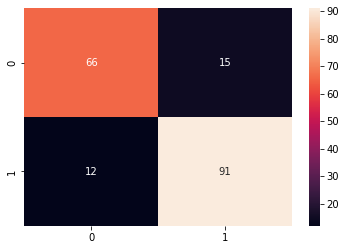

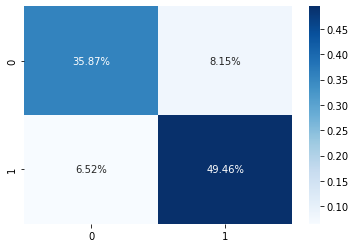

In [373]:
y_pred = (model_ANN.predict(x_test) > 0.5).astype(int)
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(1)
sns.heatmap(cf_matrix, annot=True)
plt.figure(2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')